# Temperature-Dependent EIS Analysis Part 2: Post-RelaxIS Processing

As of February 2026, this is the most up-to-date EIS analysis and processing code that we have for the Maughan lab. This is the second installation of the analysis code where you will import all your data from RelaxIS, calculate and propagate associated errors for:
* ionic conductivity
* hopping frequencies
* Ea
* ∆Hm
* conductivity prefactor
* hopping frequency prefactor

make pretty:

* temperature-dependent/overlain Nyquist plots
* Arrhenius plots

and export:

* all your pretty plots
* renamed copies of the RelaxIS output spectra with temp and replicate number
* Arrhenius .csvs
* fitted parameters in LaTex table formatting for your SI

In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
from PyEIS import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import rc
import matplotlib.ticker as ticker
import csv
import glob
import statistics
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import math
from math import pi
import re
from collections import defaultdict
import random
from scipy import stats

#make the fonts in all parts of the figure size 16
mpl.rcParams.update({
    'font.size': 16,         
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 16,
})

rc('text',usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']},size='16')
rc('text.latex', preamble=r'\usepackage{sfmath}')

In the cell below, you will specify:

1. Where your exported RelaxIS parameter file lives.
2. Where your exported RelaxIS spectra live.
3. The folder where you will export the Arrhenius data and LaTex parameter table csvs.
4. Sample name and material name (use Latex formatting for material name)
5. Diameter and height (as well as associated error) of your pellet in mm

In [2]:
#this is the file with the fit parameters from RelaxIS
RelaxIS_parameter_file =  '/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_3_023_Li6PS5OCN/SLG_3_023_Li6PS5OCN/SLG_3_023_Li6PS5OCN_1/SLG_3_023_Li6PS5OCN_1_fit_parameters.txt'

#this is the folder in which all of your exported spectra/fits from RelaxIS live
RelaxIS_spectra_folder="/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_3_023_Li6PS5OCN/SLG_3_023_Li6PS5OCN/SLG_3_023_Li6PS5OCN_1/fits"

#This is the folder in which your exported data will be saved (subfolders will be generated later.)
save_folder="/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_3_023_Li6PS5OCN/SLG_3_023_Li6PS5OCN/SLG_3_023_Li6PS5OCN_1/final_exports"

#set this flag to True if you are ready to export fitted datasets
ready2export=True

#samplename and materialname are included in output files, so change them as appropriate, used in generating figure titles and metadata
samplename='SLG_3_023_Li6PS5OCN_1'
materialname='Li$_{6}$PS$_{5}$OCN'

#INPUT DIAMETER AND HEIGHT OF PELLET HERE!
#diameter in mm
diameter = 6
#pellet height in mm
height = 1.112

#Errors in the thickness and height, generally no need to change this.
#err in pellet diameter (mm)
diameter_err=0.01
#err in pellet height (mm)
height_err=0.001

This time it is an even more gigantic function block, godspeed friend

In [25]:
#Shelby's function: import parameter file from RelaxIS, generate dataframes from the RelaxIS exported spectra .txt files 
#calculate conductivity and hopping frequency, and organizes the data into a dictionary grouping by temperature
def import_from_RelaxIS(parameter_file,RelaxIS_spectra_folder,start_color,end_color):
    parameter_dict = {} #create a dictionary to store the fit parameters
    parameter_df = pd.read_csv(parameter_file, skiprows=2, delimiter='\t',encoding='latin1',header=0) # Read the file, skipping the first 2 rows to get to the header 
    for idx, row in parameter_df.iterrows(): #iterate over the rows of the RelaxIS parameter file, where rows are separate spectra
        replicate = int(re.search(r"replicate_(\d+)_", str(row)).group(1)) #extract the replicate number from the filename column
        T = parameter_df['Temperature'][idx] #extract T
        R1 = parameter_df['Resistance 1: value'][idx] #extract R1
        alpha1 = parameter_df['CPE Alpha 1: value'][idx] #extract alpha1
        Q1 = parameter_df['CPE Q 1: value'][idx] #extract Q1
        alpha2 = parameter_df['CPE Alpha 2: value'][idx] #extract alpha 2
        Q2 = parameter_df['CPE Q 2: value'][idx] #extract Q2
        params = {'R1':R1,'alpha1':alpha1,'Q1':Q1,'alpha2':alpha2,'Q2':Q2} #make a little dictionary with each value identified by a string as its key, to be more easily compatible with other equivalent circuits
        parameter_dict[T,replicate]=params

    spectra_dict = {} #create a dictionary to store the spectra
    # Iterate through the RelaxIS exported spectra
    spectra = sorted([f for f in os.listdir(RelaxIS_spectra_folder) if f.endswith('.txt')])
    for file in spectra:
        file_path = os.path.join(RelaxIS_spectra_folder,file)
        with open(file_path, "r") as f:
            metadata_line = f.readlines()[3]
        T = int(re.search(r"T=(-?\d+)", metadata_line).group(1)) #extract the temperature
        A = float(re.search(r"A=(-?\d*\.?\d+)", metadata_line).group(1)) #extract the area
        d = float(re.search(r"d=(-?\d*\.?\d+)", metadata_line).group(1)) #extract the thickness
        replicate = int(re.search(r"replicate_(\d+)_", metadata_line).group(1)) #extract the replicate number
        df = pd.read_csv(file_path, skiprows=2, delimiter='\t',encoding='latin1', header=0) # Read the file, skipping the first 2 rows to get to the header 
        df = df.drop([0]) # Drop the row with metadata
        df = df.reset_index(drop=True) # Reset the index 
        df=df.apply(pd.to_numeric, errors="coerce") #change all the datatypes to floats - for some reason they were being read as strings
        spectra_dict[T,replicate,file_path]=df #add the temp, replicate number, filepath, and dataframe to the spectra dictionary
    sorted_spectra_dict = sorted(spectra_dict) #sort by temperature
    # Create colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("gradient", [start_color, end_color])
    
    #key[0] is the temperature, key[1] is the replicate number
    # Normalize the number of replicates globally (across all temperatures) for color gradient purposes, I think
    all_keys = [key[0] for key in spectra_dict.keys()]
    norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))
    
    # Group DataFrames by key[0], which is the temperature
    grouped_nyquist = defaultdict(list)
    for key, df in spectra_dict.items():
         grouped_nyquist[key[0]].append((key, df))
            
    #sort grouped dataframes by temperature
    grouped_nyquist = dict(sorted(grouped_nyquist.items()))
        
    # Sort each group's dataframes by key[1], which is the replicate number 
    for group_key in grouped_nyquist:
        grouped_nyquist[group_key].sort(key=lambda x: x[0][1])

    #Merge the parameter dictionary and the spectra dictionary
    #iterate over the temperature groups in the grouped_nyquist dictionary
    for temp in grouped_nyquist:
        dataframes = grouped_nyquist[temp]
        for i, (original_key, df_original) in enumerate(dataframes):
            replicate = original_key[1]
            params = parameter_dict[temp,replicate] #find the corresponding parameter values from the parameter dict
            new_key = (original_key,df_original,params)
            dataframes[i]=new_key #overwrite the old key with a new one that includes the parameters

    return grouped_nyquist

#adapted from Austin's old function
#Function takes R1, diameter, and height of pellet to get ionic conductivity and standard error in ionic conductivity (not confidence interval)
#Shelby's addition: also calculates hopping frequency (omega_p)
def calculate_IC_and_associated_error(grouped_Nyquist,print_values=True,alpha=0.05): 
    #mm to cm
    area = (((diameter)/20)**2)*np.pi
    area_err=(((diameter_err)/20)**2)*np.pi
    #print(area)
    #mm to cm
    height_cm=height/10
    height_cm_err=height_err/10
    
    #Shelby's code for iterating over grouped_nyquist to get to parameters
    #iterate over the temperature groups in the grouped_nyquist dictionary
    # Group data by temperature
    grouped_R1 = {}
    grouped_Q1 = {}
    grouped_alpha1 = {}
    for temp in grouped_nyquist:
        dataframes = grouped_nyquist[temp]
        for i, (key, df, params) in enumerate(dataframes):
            if temp not in grouped_R1:
                grouped_R1[temp] = []
            if temp not in grouped_Q1:
                grouped_Q1[temp] = []
            if temp not in grouped_alpha1:
                grouped_alpha1[temp] = []
            grouped_R1[temp].append(params['R1'])
            grouped_Q1[temp].append(params['Q1'])
            grouped_alpha1[temp].append(params['alpha1'])

    ic={}
    ic_err={}
    R1={}
    num_rep={}
    dof={}
    t_val={}
    ic_ci={}
    Q1={}
    inv_alpha1={}
    omega_p={}
    omega_p_err={}
    omega_p_ci={}
    for i,((temp, R1_values),(temp,Q1_values),(temp,alpha1_values))  in enumerate(zip(grouped_R1.items(),grouped_Q1.items(),grouped_alpha1.items())):
        num_rep[temp]=len(grouped_R1[temp])
        R1_avg = np.mean(R1_values)
        R1_std_dev = np.std(R1_values)
        R1[temp] = {'R1_average': R1_avg, 'R1_std_dev': R1_std_dev}
        ic[temp]=(1/R1[temp]['R1_average'])*(height_cm/area)
        ic_err[temp]=(math.sqrt(((R1[temp]['R1_std_dev']/R1[temp]['R1_average'])**2)+((height_cm_err/height_cm)**2)+((area_err/area)**2)))*ic[temp]
        dof[temp]=num_rep[temp]-1
        t_val[temp]=stats.t.isf(alpha/2,dof[temp])
        ic_ci[temp]=(t_val[temp]*ic_err[temp])/(sqrt(num_rep[temp]))
        #shelby's code for calculating hopping frequency
        Q1_avg = np.mean(Q1_values)
        Q1_std_dev = np.std(Q1_values)
        Q1[temp] = {'Q1_average': Q1_avg, 'Q1_std_dev': Q1_std_dev}
        alpha1_avg=np.mean(alpha1_values)
        inv_alpha1_values = 1/np.array(alpha1_values)
        inv_alpha1_avg = np.mean(inv_alpha1_values)
        inv_alpha1_std_dev = np.std(inv_alpha1_values)
        inv_alpha1[temp] = {'inv_alpha1_average': inv_alpha1_avg, 'inv_alpha1_std_dev': inv_alpha1_std_dev}
        _1_over_RQ_avg = np.mean(1/(np.array(Q1_values)*np.array(R1_values)))
        omega_p[temp] = (1/(Q1[temp]['Q1_average']*R1[temp]['R1_average']))**(1/alpha1_avg)#(inv_alpha1[temp]['inv_alpha1_average'])
        _1_over_RQ_err=(math.sqrt(((R1[temp]['R1_std_dev']/R1[temp]['R1_average'])**2)+((Q1[temp]['Q1_std_dev']/Q1[temp]['Q1_average'])**2)))*_1_over_RQ_avg
        omega_p_err[temp]=omega_p[temp]*sqrt((inv_alpha1[temp]['inv_alpha1_average']*_1_over_RQ_err/_1_over_RQ_avg)**2+(np.log(_1_over_RQ_avg)*inv_alpha1[temp]['inv_alpha1_std_dev'])**2)
        omega_p_ci[temp]=(t_val[temp]*omega_p_err[temp])/(sqrt(num_rep[temp]))
    
    
    #conductivity calculation for each replicate
    #for our purposes, this is for exporting the final dataframe
    sigma = {}
    for temp in grouped_nyquist:
        dataframes = grouped_nyquist[temp]
        for i, (key, df, params) in enumerate(dataframes):
            value = params['R1']
            sigmax = (1/ value)*(height_cm/area)
            sigma[key] = sigmax #note: I'm not totally sure what Austin's key was supposed to be here, but I'm using
            #the same key as for the previous dictionaries
    
    if print_values:
        for temp,values in ic.items():
            print(fr'The 95% confidence interval for the ionic conductivity at {temp} degrees C is {ic[temp]:.2e}({ic_ci[temp]:.2e}) S/cm')
    return ic, ic_err, ic_ci, sigma, omega_p, omega_p_err, omega_p_ci

#shelby's function
#plot one replicate at each temperature in one 2 panel Nyquist plot (high temp on left, low temp on right)
#normalize is a Boolean to determine if you want to normalize your axes by area and height of pellet
#partly adapted from Austin's plotting functions
def slg_plot_nyquists(grouped_nyquist,normalize,limit_scalar=1.25):
    sorted_grouped_nyquist = dict(sorted(grouped_nyquist.items()))
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 6))
    fig.suptitle(fr'{materialname}', y=0.92,fontsize=16)
    #color shenanigans
    temps = sorted([t for t in grouped_nyquist]) #get the temps
    custom_cmap = LinearSegmentedColormap.from_list('cmap', ['darkslateblue','mediumorchid','hotpink'])
    colors = custom_cmap(np.linspace(0, 1, int(len(temps)))) #make a list of colors that is equiv. in length to list of temps
    markers=['o','^','s','d'] 
    temp_color_dict={} #create a dictionary for temps, colors, and markers for plotting
    for temp,color,i in zip(temps,colors,range(4,len(temps)+4)): #start the index at 4 and count till the list is done
        marker = markers[mod(i,4)] #use the remaining whole number after dividing the index by 4 as the index for the marker
        temp_color_dict[temp]=color,marker
        
        
    for i,temp in enumerate(grouped_nyquist):
        dataframes = grouped_nyquist[temp]
        for old_key,df,parameters_key in dataframes:
            normconstant = generate_normalization_constant(diameter, height)
            replicate = old_key[1]
            color = temp_color_dict[temp][0]
            marker = temp_color_dict[temp][1]
            if replicate == 1: #only plot the first replicate
                label=(f'{temp} $^\circ$C')
                if i>3: #high temperature subplot
                    if i == 4: #this will select the lowest temp of the 5 high temps with a "fit" label for the legend
                        if normalize:
                            ax1.plot(df['Fit: Z\'']* normconstant,-1*np.array(df['Fit: Z\'\''])* normconstant,linestyle='solid',color='black',label = 'fit')
                            ax1.plot(df['Data: Z\'']* normconstant,-1*np.array(df['Data: Z\'\''])* normconstant,marker=marker,linestyle='none',color='white',markeredgecolor=color,markeredgewidth=2,label=label)
                            wlim_high_T = parameters_key['R1']*limit_scalar * normconstant #use the R1 value for the lowest T for the limit
                        else: #no normalization
                            wlim_high_T = parameters_key['R1']*limit_scalar #use the R1 value for the lowest T for the limit
                            ax1.plot(df['Fit: Z\''],-1*np.array(df['Fit: Z\'\'']),linestyle='solid',color='black',label = 'fit')
                            ax1.plot(df['Data: Z\''],-1*np.array(df['Data: Z\'\'']),marker=marker,linestyle='none',color='white',markeredgecolor=color,markeredgewidth=2,label=label)
                    else: #all temps besides the lowest don't have a "fit" label in the legend
                        if normalize:
                            ax1.plot(df['Fit: Z\'']* normconstant,-1*np.array(df['Fit: Z\'\''])* normconstant,linestyle='solid',color='black')
                            ax1.plot(df['Data: Z\'']* normconstant,-1*np.array(df['Data: Z\'\''])* normconstant,marker=marker,linestyle='none',color='white',markeredgecolor=color,markeredgewidth=2,label=label)
                        else: #no normalization
                            ax1.plot(df['Fit: Z\''],-1*np.array(df['Fit: Z\'\'']),linestyle='solid',color='black')
                            ax1.plot(df['Data: Z\''],-1*np.array(df['Data: Z\'\'']),marker=marker,linestyle='none',color='white',markeredgecolor=color,markeredgewidth=2,label=label)
                    
                    #a lot of axis formatting business
                    ax1.set_box_aspect(1)
                    ax1.set_xlim(0, wlim_high_T)
                    ax1.set_ylim(0, wlim_high_T)
                    prefix = labelprefix(wlim_high_T)
                    def custom_formatter(wlim_high_T):
                        def formatter(x, pos):
                            return format_axis(x, pos, wlim_high_T)
                        return formatter
                    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter(wlim_high_T)))
                    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter(wlim_high_T)))
                    tick_spacing=get_round_locator_spacing(wlim_high_T)
                    locator = ticker.MultipleLocator(tick_spacing)
                    ax1.xaxis.set_major_locator(locator)
                    ax1.yaxis.set_major_locator(locator)
                    if normalize:
                        ax1.set_xlabel(rf'Z$_{{real}}\cdot$(A/t) [{prefix}$\Omega$$\cdot$cm]')
                        ax1.set_ylabel(rf'-Z$_{{imag}}\cdot$(A/t) [{prefix}$\Omega$$\cdot$cm]')
                    else:
                        ax1.set_xlabel(rf'Z$_{{real}}$ [{prefix}$\Omega$]')
                        ax1.set_ylabel(rf'-Z$_{{imag}}$ [{prefix}$\Omega$]')
                    for spine in ax1.spines.values():
                        spine.set_linewidth(2)
                    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
                    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
                    ax1.tick_params(which='major',direction='in',length=6,right=True, top=True,left=True,bottom=True)
                    ax1.tick_params(which='minor',direction='in',length=4,right=True, top=True,left=True,bottom=True)
                    fig.text(0.45,0.2,'$\omega$',fontsize=16)
                    
                else: #low temperature subplot, picks the 4 lowest temps
                    if i == 0: #this selects the lowest temp for plotting with a "fit" label for the legend
                        if normalize:
                            ax2.plot(df['Fit: Z\'']* normconstant,-1*np.array(df['Fit: Z\'\''])* normconstant,linestyle='solid',color='black',label = 'fit')
                            ax2.plot(df['Data: Z\'']* normconstant,-1*np.array(df['Data: Z\'\''])* normconstant,marker=marker,linestyle='none',color='white',markeredgecolor=color,markeredgewidth=2,label=label)
                            wlim_low_T = parameters_key['R1']*limit_scalar * normconstant #use the R1 value for the lowest T for the limit
                        else: #no normalization
                            ax2.plot(df['Fit: Z\''],-1*np.array(df['Fit: Z\'\'']),linestyle='solid',color='black',label = 'fit')
                            ax2.plot(df['Data: Z\''],-1*np.array(df['Data: Z\'\'']),marker=marker,linestyle='none',color='white',markeredgecolor=color,markeredgewidth=2,label=label)
                            wlim_low_T = parameters_key['R1']*limit_scalar #use the R1 value for the lowest T for the limit
                    else: #all other temps plotted without "fit" label in legend
                        if normalize:
                            ax2.plot(df['Fit: Z\'']* normconstant,-1*np.array(df['Fit: Z\'\''])* normconstant,linestyle='solid',color='black')
                            ax2.plot(df['Data: Z\'']* normconstant,-1*np.array(df['Data: Z\'\''])* normconstant,marker=marker,linestyle='none',color='white',markeredgecolor=color,markeredgewidth=2,label=label)
                        else: #no normalization
                            ax2.plot(df['Fit: Z\''],-1*np.array(df['Fit: Z\'\'']),linestyle='solid',color='black')
                            ax2.plot(df['Data: Z\''],-1*np.array(df['Data: Z\'\'']),marker=marker,linestyle='none',color='white',markeredgecolor=color,markeredgewidth=2,label=label)
                   
                    #a lot of axis formatting business
                    ax2.set_box_aspect(1)
                    ax2.set_xlim(0, wlim_low_T)
                    ax2.set_ylim(0, wlim_low_T)
                    prefix = labelprefix(wlim_low_T)
                    def custom_formatter(wlim_low_T):
                        def formatter(x, pos):
                            return format_axis(x, pos, wlim_low_T)
                        return formatter
                    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter(wlim_low_T)))
                    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter(wlim_low_T)))
                    tick_spacing=get_round_locator_spacing(wlim_low_T)
                    locator = ticker.MultipleLocator(tick_spacing)
                    ax2.xaxis.set_major_locator(locator)
                    ax2.yaxis.set_major_locator(locator)
                    if normalize:
                        ax2.set_xlabel(rf'Z$_{{real}}\cdot$(A/t) [{prefix}$\Omega$$\cdot$cm]')
                        ax2.set_ylabel(rf'-Z$_{{imag}}\cdot$(A/t) [{prefix}$\Omega$$\cdot$cm]')
                    else:
                        ax2.set_xlabel(rf'Z$_{{real}}$ [{prefix}$\Omega$]')
                        ax2.set_ylabel(rf'-Z$_{{imag}}$ [{prefix}$\Omega$]')
                    for spine in ax2.spines.values():
                        spine.set_linewidth(2)
                    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
                    ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
                    ax2.tick_params(which='major',direction='in',length=6,right=True, top=True,left=True,bottom=True)
                    ax2.tick_params(which='minor',direction='in',length=4,right=True, top=True,left=True,bottom=True)
            
    #format the legend for high T subplot - note: in my case, I actually had 5 high temps          
    handles, labels = ax1.get_legend_handles_labels()
    order = [1, 2, 3, 4,5, 0]  # New order for all raw data followed by fit
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax1.legend(handles,labels,framealpha=0,loc='upper right',bbox_to_anchor=(0.95,0.97),bbox_transform=ax1.transAxes,handlelength=1,fontsize=16)
    
    #format the legend for low T subplot - note: in my case, I had 4 low temps 
    handles, labels = ax2.get_legend_handles_labels()
    order = [1, 2, 3, 4, 0]  # New order for all raw data followed by fit
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax2.legend(handles,labels,framealpha=0,loc='upper right',bbox_to_anchor=(0.95,0.97),bbox_transform=ax2.transAxes,handlelength=1,fontsize=16)
    save_file_name = f'T_dep_Nyquist_{samplename}'
    save_figure(fig=fig,filename=save_file_name,save_folder=save_folder,save_sub_folder='figs')
    plt.show()
            
    
#Shelby's function for exporting nyquist dataframes with useful filenames
def export_renamed_RelaxIS_spectra(RelaxIS_spectra_folder):
    # Iterate through the RelaxIS exported spectra
    spectra = sorted([f for f in os.listdir(RelaxIS_spectra_folder) if f.endswith('.txt')])
    for file in spectra:
        file_path = os.path.join(RelaxIS_spectra_folder,file)
        with open(file_path, "r") as f:
            metadata_line = f.readlines()[3]
        T = str(re.search(r"T=(-?\d+)", metadata_line).group(1)) #extract the temperature
        A = float(re.search(r"A=(-?\d*\.?\d+)", metadata_line).group(1)) #extract the area
        d = float(re.search(r"d=(-?\d*\.?\d+)", metadata_line).group(1)) #extract the thickness
        replicate = str(re.search(r"replicate_(\d+)_", metadata_line).group(1)) #extract the replicate number
        with open(file_path, "r") as fin:
            lines = fin.readlines()
        new_filename = T+"C_replicate_"+replicate+'.txt'
        output_file_path = os.path.join(save_folder, 'renamed_fitted_Nyquists', f"{new_filename}")
        if not os.path.isdir(f"{save_folder}/renamed_fitted_Nyquists"):
            os.makedirs(f"{save_folder}/renamed_fitted_Nyquists")
        with open(output_file_path, "w") as fout:
            fout.writelines(lines)

#Austin's function
# Define a function to format the axis multiplier
def format_axis(value, tick_number, limit):
    if limit >= 5e9:
        value = value / 1e9
    elif limit >= 5e6:
        value = value / 1e6
    elif limit >= 5e3:
        value = value / 1e3
    return '{:.0f}'.format(value)

#Austin's function
# Define a function to format the axis label unit
def labelprefix(limit):
    prefix = ''
    if limit >= 5e9:
        prefix = 'G'
    elif limit >= 5e6:
        prefix = 'M'
    elif limit >= 5e3:
        prefix = 'k'
    return prefix

#Austin's function
def get_round_locator_spacing(limit):
    # Choose a "nice" base spacing based on the axis limit
    scaler=1
    if limit >= 5e9:
        scaler=1e9
    elif limit >= 5e6:
        scaler= 1e6
    elif limit >= 5e3:
        scaler=1e3
    if limit > 5000*scaler:
        return 1000*scaler
    elif limit > 2000*scaler:
        return 500*scaler
    elif limit > 1000*scaler:
        return 250*scaler
    elif limit > 500*scaler:
        return 100*scaler
    elif limit > 200*scaler:
        return 50*scaler
    elif limit > 100*scaler:
        return 20*scaler
    elif limit > 50*scaler:
        return 10*scaler
    elif limit > 20*scaler:
        return 5*scaler
    elif limit > 10*scaler:
        return 2*scaler
    else:
        return 1*scaler

#Austin's function    
def generate_normalization_constant(diameter,height):
    area=pi*(((diameter/10)/2)**2)
    heightcm=height/10
    normconstant=area/heightcm
    return normconstant

#Austin's function
#this function calculates the confidence intervals for relevant parameters in the arrhenius fit
def Ea_confidence_interval( x, y, y_fit, slope, intercept, E, alpha=0.05, print_values=True):
    #calculate the residual errors for the data (r=(y-ypredicted))
    residuals=y-y_fit
    #print('the residual errors are:',residuals)
    k=8.6173303e-5
    #calculate the total residual error (R=sum(y-ypredicted)^2)
    total_residual_error=sum(residuals**2)
    
    
    #calculate the standard deviation about the regression (Sr=rt((total residual error)/(n-2))), n= number of data points
    n=len(x)
    
    dof=n-2
    std_dev_reg=math.sqrt(total_residual_error/dof)
    
    
    #calculate the standard deviations in the slope and intercept
    meanx=np.mean(x)
    std_dev_slope=std_dev_reg/math.sqrt((sum((x-meanx)**2)))
    std_dev_int=std_dev_reg*math.sqrt((sum(x**2))/(n*sum((x-meanx)**2)))
    
    
    #calculate the student's t-distribution value
    t_val=stats.t.isf(alpha/2,dof)
    
    
    #calculate the confidence intervals for the slope and intercept
    CI_slope=std_dev_slope*t_val
    
    CI_int=std_dev_int*t_val
    
    
    #calculate uncertainty in activation energy (if m=-E/k, uncertainty in E is uncertainty in m*-1*k)
    CI_E=CI_slope*k
    
    if print_values:
        print(f"Total residual error: {total_residual_error:.2e}")
        print(f"Number of data points: {n}")
        print(f"Standard deviation about the regression: {std_dev_reg:.3f}")
        print(f"Standard deviation in the slope: {std_dev_slope:.3f}")
        print(f"Standard deviation in the intercept: {std_dev_int:.3f}")
        print(f"t value: {t_val:.3f}")
        print(f'the {(1 - alpha) * 100:.1f}% confidence interval for the slope is {slope[0]:.3f} ± {CI_slope:.3f}')
        print(f'the {(1 - alpha) * 100:.1f}% confidence interval for the intercept is {intercept:.3f} ± {CI_int:.3f}')
        print(f'the {(1 - alpha) * 100:.1f}% confidence interval for the activation energy is {E[0]:.3f} ± {CI_E:.3f} eV')
        
    return CI_E,CI_int,CI_slope


#Austin's function
def arrhenius_fit_and_extract_Ea_and_confidence_interval(ic,ic_err,alpha=0.05,print_values=True):

    #generate two bigboi arrays that are just the temperature and ionic conductivities
    ic_array=np.array([])
    ic_err_array=np.array([])
    t=np.array([])
    for key, data in ic.items():
        ic_array=np.append(ic_array,data)
        temp_part=key
        t=np.append(t,temp_part)
        ic_err_array=np.append(ic_err_array,ic_err[key])
    t=t.astype(float) #convert temperature strings into floats
    
    #print(t,ic_array,ic_err_array)
    
    #manipulate the temperature for our purposes
    t_k=t+273.15 #convert to kelvin
    tinv=1/t_k #go to inverse temperature for the plotting
    x=tinv.reshape((-1,1)) #reshape tinv to being 1 column for the purposes of the fitting
    
    #calculate the natural log of ionic conductivity times temperature. made new variable named y for simplicity in later code
    log_ic_t=np.log(ic_array*t_k)
    y=log_ic_t #make a new variable called y because y not?
    
    #calculate relative error in the data points, used to weight the fit.
    y_err_weighting=(ic_err_array)/(ic_array)
    
    k=8.6173303e-5
    
    #now we do a linear fit of the data, y=mx+b, where ln(ic*T)=y, -E/k=m, 1/T=x,ln(A)=b
    model=LinearRegression()
    model.fit(x,y,sample_weight=1/y_err_weighting)
    
    
    r_sq=model.score(x,y,sample_weight=1/y_err_weighting)
   
    
    #calculate activation energy via m=-E/k-->-m*k=E
    E=-1*model.coef_*k

    #call and print the y intercept (ln(A))
    #call and print the slope (-E/k)
    #call and print the r^2 value of the fit
    if print_values:
        print('\033[1m'+"Conductivity Arrhenius fit statistics:"+'\033[0m')
        print(f"r² value of the fit: {r_sq:.4f}")
        print(f"y-intercept: {model.intercept_:.4f}")
        print(f"slope: {model.coef_[0]:.4f}")
        print(f"Calculated activation energy: {E[0]:.2e} eV")

    #calculate the error values
    CI_E,CI_int,CI_slope=Ea_confidence_interval(x=x,y=y,y_fit=model.predict(x),slope=model.coef_,intercept=model.intercept_, E=E,alpha=alpha,print_values=print_values)

    return r_sq, model.intercept_, model.coef_, E, CI_E, CI_int,CI_slope

#Austin's function
#prefactor fun-- we are going to calculate the prefactor and confidence interval here!
def calculate_prefactor_and_confidence_interval (y_int,CI_int,print_values=True):
    rel_interval=CI_int/y_int
    prefactor=exp(arrh_y_int)
    absolute_error=prefactor*rel_interval
    if print_values:
        print('the '+'\033[1m'+'conductivity prefactor'+'\033[0m'+f' is {prefactor:.2e}({absolute_error:.2e}) KS/cm')
        
    return prefactor, absolute_error

#Austin's function, slightly updated by Shelby to include a way to save the figure
#generates arrhenius plot! write_values adds a label with material name, sample name, activation energy, and prefactor.
def arrhenius_plot(ic,error,y_int,slope,r_squared,E, CI_E, prefactor, prefactor_error, fit_color="#3399ff", write_values=True):
    inverse_temp_kelvin={}
    temp_kelvin={}
    log_ic_T={}
    relative_error={}
    log_error={}
    for temp in ic:
        temp_kelvin[temp]=temp+273.15
        inverse_temp_kelvin[temp]=(1/(temp_kelvin[temp]))
        log_ic_T[temp]=np.log(ic[temp]*temp_kelvin[temp])
        relative_error[temp]=(error[temp]/(ic[temp]))
        log_error[temp]=relative_error[temp]*log_ic_T[temp]
        # Sort by temperature
    sorted_keys = sorted(inverse_temp_kelvin.keys())
    T_K=np.array([temp_kelvin[temp] for temp in sorted_keys])
    x_vals = np.array([inverse_temp_kelvin[temp] for temp in sorted_keys])
    y_vals = np.array([log_ic_T[temp] for temp in sorted_keys])
    y_errs = np.array([log_error[temp] for temp in sorted_keys])

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.errorbar(1000*x_vals, y_vals, yerr=np.abs(y_errs), linestyle='none', marker='o', color='black',markersize=7,capsize=7, mfc='white')
    ax.plot(1000*x_vals, slope * x_vals + y_int, linestyle='-',linewidth=2, color=fit_color, marker='None')

    ax.set_xlabel(r'1000/\textit{T} (K$^{-1}$)')
    ax.set_ylabel(r'ln($\sigma$\textit{T}) (S$\cdot$cm$^{-1}\cdot$K)')
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(which='both', direction='in', right=True, top=True)
    ax.tick_params(which='both', direction='in',length=6, right=False, top=False)
    ax.tick_params(which='minor', direction='in',length=3, right=False, top=False)
    ax.tick_params(width=2,which='both')
    if write_values:
        fig.text(.85,.85,fr'{samplename}\\{materialname}\\E$_A$={E[0]*1000:.0f}({CI_E*1000:.0f}) meV\\$\sigma_0$={prefactor:.2e}({prefactor_error:.2e})\\K$\cdot$S cm$^{-1}$\\R$^2$={r_squared:.4f}',ha='right',va='top',multialignment='right')
    save_file_name = f'conductivity_arrhenius_{samplename}'
    save_figure(fig=fig,filename=save_file_name,save_folder=save_folder,save_sub_folder='figs')
    return T_K,x_vals,y_vals,y_errs
    plt.show()

#Austin's function    
#this cell defines the function for generating arrhenius dataframe for exporting data. modify as needed.
def generate_arrhenius_df(T_K,T_K_inv,ln_sig_T,ln_sig_T_err,m,b,E,CI_E,r_sq,ic,ic_ci,prefactor,prefactor_error,samplename=samplename,materialname=materialname,show_table=True):
    #Generate a pandas dataframe with all the relevant parameters from the arrhenius fit
    slope=[m.item()]*len(T_K)
    intercept=[b]*len(T_K)
    Ea=[E.item()]*len(T_K)
    CI_Ea=[CI_E]*len(T_K)
    samplenamez=[samplename]*len(T_K)
    materialnamez=[materialname]*len(T_K)
    r_sqs=[r_sq]*len(T_K)
    conductivityz=[ic[30]]*len(T_K)
    moez=[ic_ci[30]]*len(T_K)
    moez_prefactor=[prefactor_error]*len(T_K)
    meanz_prefactor=[prefactor]*len(T_K)
    
    arrhenius_export_df = pd.DataFrame({
        r'sample name':samplenamez,
        r'material name':materialnamez,
        r'Temperature (K)':T_K,
        r'1/$\textit{T}$ (K$^{-1}$)': T_K_inv,
        r'ln($\sigma\textit{T}$) (S$\cdot$cm$^{-1}\cdot$K)': ln_sig_T,
        r'y error in ln($\sigma$\textit{T}) (confidence interval)':ln_sig_T_err,
        r'Arrhenius Slope':slope,
        r'Arrhenius Y-intercept':intercept,
        r'Arrhenius r$^2$':r_sqs,
        r'E$_A$':Ea,
        r'E$_A$ confidence interval':CI_Ea,
        r'$\sigma_{30~^\circ C}$':conductivityz,
        r'$\sigma_{30~^\circ C}$ confidence interval':moez,
        r'$\sigma_0$':meanz_prefactor,
        r'$\sigma_0$ confidence interval':moez_prefactor
    })
    if show_table:
        display(arrhenius_export_df)

    return arrhenius_export_df

#Shelby updated from Austin's previous code to pull parameters from grouped_nyquist instead of PyEIS experiments
#define function to generate latex formatted table of fitted parameters
def generate_fitted_param_table(grouped_nyquist,sigma,show_table=True):
    #leading resistor
#     R1={}
    #parallel Resistor
    R1={}
    #parallel constant phase element
    Q1={}
    alpha1={}
    #tailing constant phase element
    Q2={}
    alpha2={}
    
    capacitance={}
    char_freq={}
    
    for i,temp in enumerate(grouped_nyquist):
        dataframes = grouped_nyquist[temp]
        for old_key,df,parameters_key in dataframes:
            R1[old_key]=float(parameters_key['R1'])
            alpha1[old_key]=float(parameters_key['alpha1'])
            Q1[old_key]=float(parameters_key['Q1'])
            alpha2[old_key]=float(parameters_key['alpha2'])
            Q2[old_key]=float(parameters_key['Q2'])
            capacitance[old_key]=(((Q1[old_key]*R1[old_key])**(1/alpha1[old_key]))/R1[old_key])
            char_freq[old_key]=float((1/(Q1[old_key]*R1[old_key]))**(1/alpha1[old_key]))


    # Combine dictionaries into a single DataFrame
    refinedparams = {
        r'$T$ ($^\circ$C)': [key[0] for key in R1.keys()],
        'Replicate Scan': [key[1] for key in R1.keys()],
        #r'R$_0$ ($\Omega$)': list(R1_new.values()),
        r'$R_1$ ($\Omega$)': list(R1.values()),
        r'$\sigma$ (S cm$^{-1}$)':list(sigma.values()),
        r'$\alpha_1$': list(alpha1.values()),
        r'$Q_1$(S$\cdot$s$^\alpha$)': list(Q1.values()),
        r'$C_1$ (F)': list(capacitance.values()),
        r'$\omega_{1}$ (Rad/s)': list(char_freq.values()),
        r'$\alpha_2$': list(alpha2.values()),
        r'$Q_2$(S$\cdot$s$^\alpha$)': list(Q2.values())
        
    }
    
    refinedparams = pd.DataFrame(refinedparams)

    #r'R$_0$ ($\\Omega$)'
    columns_to_sci = [r'$R_1$ ($\Omega$)',r'$Q_1$(S$\cdot$s$^\alpha$)',r'$C_1$ (F)',r'$Q_2$(S$\cdot$s$^\alpha$)',r'$\sigma$ (S cm$^{-1}$)',r'$\omega_{1}$ (Rad/s)']
    refinedparams[columns_to_sci] = refinedparams[columns_to_sci].applymap(lambda x: f"{x:.2e}") #put these columns in scientific notation
    columns_to_round=[r'$\alpha_1$',r'$\alpha_2$']
    refinedparams[columns_to_round]=refinedparams[columns_to_round].round(2)
    #Add '&' columns and '\' at the end of each row
    for col in refinedparams.columns[:-1]:
        refinedparams.insert(refinedparams.columns.get_loc(col)+1, '&', '&',allow_duplicates=True)
    
    # Add the '\\' column at the end
    refinedparams['\\\\'] = '\\\\'
    if show_table:    
        display(refinedparams)

    return refinedparams


#shelby's functions adapted from Austin's conductivity arrhenius analysis for hopping frequency arrhenius analysis
def omega_p_arrhenius_fit_and_extract_Ea_and_confidence_interval(omega_p,omega_p_err,alpha=0.05,print_values=True):

    #generate two bigboi arrays that are just the temperature and hopping frequencies
    omega_p_array=np.array([])
    omega_p_err_array=np.array([])
    t=np.array([])
    for key, data in omega_p.items():
        omega_p_array=np.append(omega_p_array,data)
        temp_part=key
        t=np.append(t,temp_part)
        omega_p_err_array=np.append(omega_p_err_array,omega_p_err[key])
    t=t.astype(float) #convert temperature strings into floats
    
    #manipulate the temperature for our purposes
    t_k=t+273.15 #convert to kelvin
    tinv=1/t_k #go to inverse temperature for the plotting
    x=tinv.reshape((-1,1)) #reshape tinv to being 1 column for the purposes of the fitting
    
    #calculate the natural log of omega_p. made new variable named y for simplicity in later code
    log_omega_p=np.log(omega_p_array)
    y=log_omega_p #make a new variable called y because y not?
    
    #calculate relative error in the data points, used to weight the fit.
    y_err_weighting=(omega_p_err_array)/(omega_p_array)
    
    k=8.6173303e-5 #in eV*K
    
    #now we do a linear fit of the data, y=mx+b, where ln(omega_p)=y, -∆Hm/k=m, 1/T=x,ln(omega_0)+∆Sm/k=b
    model=LinearRegression()
    model.fit(x,y,sample_weight=1/y_err_weighting)
    
    
    r_sq=model.score(x,y,sample_weight=1/y_err_weighting)
   
    
    #calculate enthalpy of migration via m=-∆Hm/k-->-m*k=∆Hm
    Hm=-1*model.coef_*k

    #call and print the y intercept (ln(omega_0)+∆Sm/k=b)
    #call and print the slope (-∆Hm/k)
    #call and print the r^2 value of the fit
    if print_values:
        print('\033[1m'+"Hopping frequency Arrhenius fit statistics:"+'\033[0m')
        print(f"r² value of the fit: {r_sq:.4f}")
        print(f"y-intercept: {model.intercept_:.4f}")
        print(f"slope: {model.coef_[0]:.4f}")
        print(f"Calculated enthalpy of migration: {Hm[0]:.2e} eV")

    #calculate the error values
    CI_Hm,omega_p_CI_int,omega_p_CI_slope=Ea_confidence_interval(x=x,y=y,y_fit=model.predict(x),slope=model.coef_,intercept=model.intercept_, E=Hm,alpha=alpha,print_values=print_values)

    return r_sq, model.intercept_, model.coef_, Hm, CI_Hm, omega_p_CI_int,omega_p_CI_slope

#Shelby's function adapted from Austin's conductivity prefactor calculation
#hopping frequency prefactor calculation
def omega_p_calculate_prefactor_and_confidence_interval (omega_p_y_int,omega_p_CI_int,print_values=True):
    omega_p_rel_interval=omega_p_CI_int/omega_p_y_int
    omega_p_prefactor=exp(omega_p_arrh_y_int)
    omega_p_absolute_error=omega_p_prefactor*omega_p_rel_interval
    if print_values:
        print('the '+'\033[1m'+'hopping frequency prefactor'+'\033[0m'+f' is {omega_p_prefactor:.2e}({omega_p_absolute_error:.2e}) KS/cm')
    return omega_p_prefactor, omega_p_absolute_error


#shelby's code for plotting hopping frequency arrhenius - adapted from Austin's conductivity arrhenius plotting
#generates arrhenius plot! write_values adds a label with material name, sample name, activation energy, and prefactor.
def omega_p_arrhenius_plot(omega_p,omega_p_error,omega_p_y_int,omega_p_slope,omega_p_r_squared,Hm, CI_Hm, omega_p_prefactor, omega_p_prefactor_error, fit_color="#3399ff", write_values=True):
    inverse_temp_kelvin={}
    temp_kelvin={}
    log_omega_p={}
    relative_error={}
    log_error={}
    for temp in omega_p:
        temp_kelvin[temp]=temp+273.15
        inverse_temp_kelvin[temp]=(1/(temp_kelvin[temp]))
        log_omega_p[temp]=np.log(omega_p[temp])
        relative_error[temp]=(omega_p_error[temp]/(omega_p[temp]))
        log_error[temp]=relative_error[temp]*log_omega_p[temp]
        # Sort by temperature
    sorted_keys = sorted(inverse_temp_kelvin.keys())
    T_K=np.array([temp_kelvin[temp] for temp in sorted_keys])
    x_vals = np.array([inverse_temp_kelvin[temp] for temp in sorted_keys])
    y_vals = np.array([log_omega_p[temp] for temp in sorted_keys])
    y_errs = np.array([log_error[temp] for temp in sorted_keys])

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.errorbar(1000*x_vals, y_vals, yerr=np.abs(y_errs), linestyle='none', marker='o', color='black',markersize=7,capsize=7, mfc='white')
    ax.plot(1000*x_vals, omega_p_slope * x_vals + omega_p_y_int, linestyle='-',linewidth=2, color=fit_color, marker='None')

    ax.set_xlabel(r'1000/\textit{T} (K$^{-1}$)')
    ax.set_ylabel(r'ln($\omega_p$) (Rad/s)') #NOTE calculated hopping frequencies are angular frequencies (omega) in units of rad/s, frequencies in raw Gamry data are regular frequencies in Hz 
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(which='both', direction='in', right=True, top=True)
    ax.tick_params(which='both', direction='in',length=6, right=False, top=False)
    ax.tick_params(which='minor', direction='in',length=3, right=False, top=False)
    ax.tick_params(width=2,which='both')
    if write_values:
        fig.text(.85,.85,fr'{samplename}\\{materialname}\\$\Delta H_m$={Hm[0]*1000:.0f}({CI_Hm*1000:.0f}) meV\\ln($\omega_0$)+$\Delta$ S$_m$/k$_B$={omega_p_prefactor:.2e}({omega_p_prefactor_error:.2e})\\R$^2$={omega_p_r_squared:.4f}',ha='right',va='top')
    save_file_name = f'hopping_frequency_arrhenius_{samplename}'
    save_figure(fig=fig,filename=save_file_name,save_folder=save_folder,save_sub_folder='figs')
    plt.show()
    return T_K,x_vals,y_vals,y_errs


#Shelby's function adapted from Austin's conductivity arrhenius function
#this cell defines the function for generating hopping frequency arrhenius dataframe for exporting data. modify as needed.
def generate_omega_p_arrhenius_df(T_K,T_K_inv,ln_omega_p,ln_omega_p_err,m,b,Hm,CI_Hm,r_sq,omega_p,omega_p_ci,omega_p_prefactor,omega_p_prefactor_error,samplename=samplename,materialname=materialname,show_table=True):
    #Generate a pandas dataframe with all the relevant parameters from the arrhenius fit
    slope=[m.item()]*len(T_K)
    intercept=[b]*len(T_K)
    Hm=[Hm.item()]*len(T_K)
    CI_Hm=[CI_Hm]*len(T_K)
    samplenamez=[samplename]*len(T_K)
    materialnamez=[materialname]*len(T_K)
    r_sqs=[r_sq]*len(T_K)
    omega_pz=[omega_p[30]]*len(T_K)
    moez=[omega_p_ci[30]]*len(T_K) #margion of error
    moez_prefactor=[omega_p_prefactor_error]*len(T_K)
    meanz_prefactor=[omega_p_prefactor]*len(T_K)
    
    arrhenius_export_df = pd.DataFrame({
        r'sample name':samplenamez,
        r'material name':materialnamez,
        r'Temperature (K)':T_K,
        r'1/$\textit{T}$ (K$^{-1}$)': T_K_inv,
        r'ln($\omega_p$) (Rad/s)': ln_omega_p,
        r'y error in ln($\omega_p$) (confidence interval)':ln_omega_p_err,
        r'Arrhenius Slope':slope,
        r'Arrhenius Y-intercept':intercept,
        r'Arrhenius r$^2$':r_sqs,
        r'$\Delta$H$_m$':Hm,
        r'$\Delta$H$_m$ confidence interval':CI_Hm,
        r'$\omega_{p~30~^\circ C}$':omega_pz,
        r'$\omega_{p~30~^\circ C}$ confidence interval':moez,
        r'ln($\omega_0$)+$\Delta$ S$_m$/k$_B$':meanz_prefactor,
        r'ln($\omega_0$)+$\Delta$ S$_m$/k$_B$ confidence interval':moez_prefactor
    })
    if show_table:
        display(arrhenius_export_df)

    return arrhenius_export_df

#Austin's function
#save dataframe as a .csv in the save_folder. if specified, save_sub_folder will be added to the file path 
#the file will be saved as {samplename}_{cleaned_matname}_{savename}.csv, where unallowed characters from the material name will be removed.
def clean_matname_and_save (dataframe, save_folder, savename, save_sub_folder=None, samplename=samplename, materialname=materialname):

    #filter non-alphanumeric and space characters from the material name so that it's easier to deal with from a file management perspective
    cleaned_matname = filter(lambda x: x.isalnum() or x.isspace(), materialname)
    
    # filter returns a generator, so we need to re-join the string
    cleaned_matname = "".join(cleaned_matname)

    #this will be the folder into which we whang all of the dataframes, named based on the sample and material name
    filename=f"{samplename}_{cleaned_matname}_{savename}.csv"


    #here we save all of our dataframes! don't want to miss out on any yummy data, so we save it all
    #the save format is temp_30_replicate_1_1-107A Pellet 2_SSM Li6PS5Cl, obviously different if your materials aren't exactly like mine
    if save_sub_folder:
        if not os.path.isdir(f"{save_folder}/{save_sub_folder}"):
            os.makedirs(f"{save_folder}/{save_sub_folder}")
        dataframe.to_csv(f"{save_folder}/{save_sub_folder}/{filename}")

    else:
        if not os.path.isdir(f"{save_folder}"):
            os.makedirs(f"{save_folder}")
        dataframe.to_csv(f"{save_folder}/{filename}")
        
#Shelby's function to save figures in similar subfolder organization to Austin's clean_matname_and_save above
def save_figure(fig,filename,save_folder,save_sub_folder):
    if save_sub_folder:
        if not os.path.isdir(f"{save_folder}/{save_sub_folder}"):
            os.makedirs(f"{save_folder}/{save_sub_folder}")
        fig.savefig(f"{save_folder}/{save_sub_folder}/{filename}.png", dpi=300, bbox_inches="tight",facecolor='white')
    else:
        if not os.path.isdir(f"{save_folder}"):
            os.makedirs(f"{save_folder}")
        dataframe.to_csv(f"{save_folder}/{filename}")
        fig.savefig(f"{save_folder}/{filename}.png", dpi=300, bbox_inches="tight",facecolor='white')

Woof you made it - start actually running the code below

The 95% confidence interval for the ionic conductivity at -60 degrees C is 1.43e-07(3.19e-10) S/cm
The 95% confidence interval for the ionic conductivity at -45 degrees C is 5.96e-07(2.27e-09) S/cm
The 95% confidence interval for the ionic conductivity at -30 degrees C is 2.25e-06(1.95e-08) S/cm
The 95% confidence interval for the ionic conductivity at -15 degrees C is 6.70e-06(3.90e-08) S/cm
The 95% confidence interval for the ionic conductivity at 0 degrees C is 1.77e-05(9.73e-08) S/cm
The 95% confidence interval for the ionic conductivity at 15 degrees C is 4.41e-05(1.32e-07) S/cm
The 95% confidence interval for the ionic conductivity at 30 degrees C is 9.97e-05(2.42e-07) S/cm
The 95% confidence interval for the ionic conductivity at 45 degrees C is 2.34e-04(5.30e-07) S/cm
The 95% confidence interval for the ionic conductivity at 60 degrees C is 5.01e-04(1.63e-06) S/cm
Conductivity Arrhenius fit statistics:
r² value of the fit: 0.9995
y-intercept: 13.2182
slope: -5044.2744
Calculate

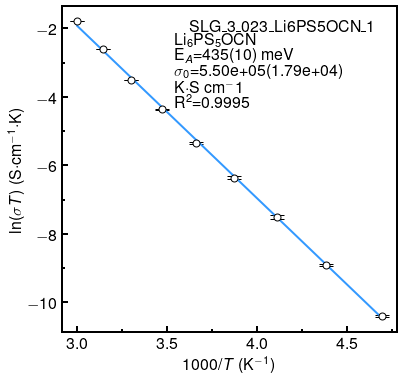

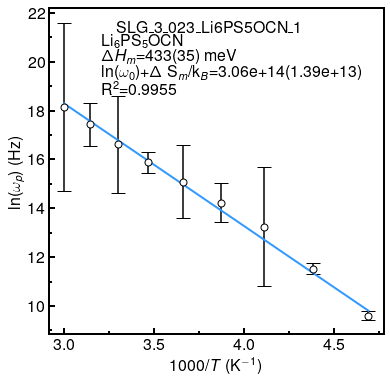

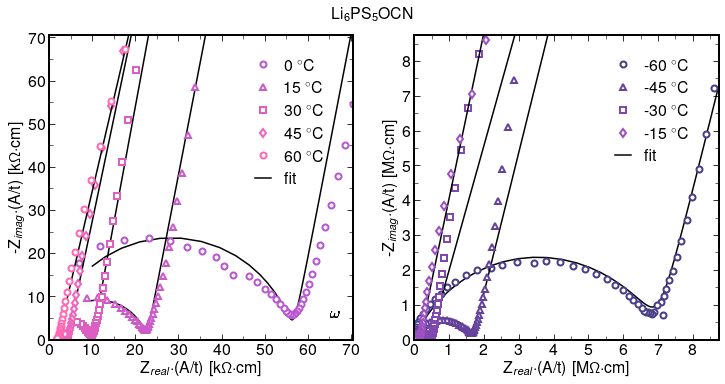

,$T$ ($^\circ$C),&,Replicate Scan,&,$R_1$ ($\Omega$),&,$\sigma$ (S cm$^{-1}$),&,$\alpha_1$,&,$Q_1$(S$\cdot$s$^\alpha$),&,$C_1$ (F),&,$\omega_{1}$ (Rad/s),&,$\alpha_2$,&,$Q_2$(S$\cdot$s$^\alpha$),\\
0,-60,&,1,&,2.75e+06,&,1.43e-07,&,0.75,&,2.69e-10,&,2.43e-11,&,1.49e+04,&,0.85,&,2.77e-08,\\
1,-60,&,2,&,2.75e+06,&,1.43e-07,&,0.75,&,2.69e-10,&,2.43e-11,&,1.49e+04,&,0.84,&,2.79e-08,\\
2,-60,&,3,&,2.75e+06,&,1.43e-07,&,0.75,&,2.72e-10,&,2.47e-11,&,1.47e+04,&,0.84,&,2.81e-08,\\
3,-45,&,1,&,6.58e+05,&,5.97e-07,&,0.80,&,1.49e-10,&,1.48e-11,&,1.02e+05,&,0.85,&,3.39e-08,\\
4,-45,&,2,&,6.60e+05,&,5.96e-07,&,0.80,&,1.51e-10,&,1.51e-11,&,1.00e+05,&,0.85,&,3.37e-08,\\
5,-45,&,3,&,6.60e+05,&,5.96e-07,&,0.80,&,1.49e-10,&,1.48e-11,&,1.02e+05,&,0.85,&,3.38e-08,\\
6,-30,&,1,&,1.74e+05,&,2.26e-06,&,0.92,&,2.80e-11,&,1.00e-11,&,5.74e+05,&,0.83,&,4.46e-08,\\
7,-30,&,2,&,1.75e+05,&,2.25e-06,&,0.92,&,2.84e-11,&,1.01e-11,&,5.65e+05,&,0.83,&,4.45e-08,\\
8,-30,&,3,&,1.76e+05,&,2.24e-06,&,0.92,&,3.15e-11,&,1.03e-11,&,5.52e+05,&,0.83,&,4.41e-08,\\
9,-15,&,1,&,5.85e+04,&,6.72e-06,&,0.90,&,4.60e-11,&,1.13e-11,&,1.51e+06,&,0.87,&,4.22e-08,\\


In [26]:
#import RelaxIS parameters, spectra, and fits and group all data by temperature
grouped_nyquist = import_from_RelaxIS(RelaxIS_parameter_file,RelaxIS_spectra_folder,start_color="#3399ff", end_color="#ff66ff")

#calculate ionic conductivity, error, and confidence intervals and hopping frequency, error, and confidence intervals
ic, ic_err, ic_ci, sigma, omega_p, omega_p_err, omega_p_ci =calculate_IC_and_associated_error(grouped_nyquist,print_values=True,alpha=0.05)

#this function does the conductivity arrhenius fit!
arrh_r_sq, arrh_y_int, arrh_slope, E, CI_E, CI_int, CI_slope=arrhenius_fit_and_extract_Ea_and_confidence_interval(ic=ic,ic_err=ic_err,alpha=0.05,print_values=True)

#hopping frequency arrhenius fit
omega_p_arrh_r_sq, omega_p_arrh_y_int, omega_p_arrh_slope, Hm, CI_Hm, omega_p_CI_int, omega_p_CI_slope=omega_p_arrhenius_fit_and_extract_Ea_and_confidence_interval(omega_p=omega_p,omega_p_err=omega_p_err,alpha=0.05,print_values=True)

#conductivity prefactor fun-- we are going to calculate the prefactor and confidence interval here!
prefactor, prefactor_error=calculate_prefactor_and_confidence_interval (arrh_y_int,CI_int,print_values=True)

#calculate the hopping frequency prefactor and confidence interval here!
omega_p_prefactor, omega_p_prefactor_error=omega_p_calculate_prefactor_and_confidence_interval (omega_p_arrh_y_int,omega_p_CI_int,print_values=True)

#This function makes the conductivity arrhenius plot
T_K,T_K_inv,ln_sig_T,ln_sig_T_err=arrhenius_plot(ic=ic, error=ic_ci, y_int=arrh_y_int, slope=arrh_slope,r_squared=arrh_r_sq,E=E, CI_E=CI_E, prefactor=prefactor, prefactor_error=prefactor_error)

#This function makes the hopping frequency arrhenius plot
T_K,T_K_inv,ln_omega_p,ln_omega_p_err=omega_p_arrhenius_plot(omega_p=omega_p, omega_p_error=omega_p_ci, omega_p_y_int=omega_p_arrh_y_int, omega_p_slope=omega_p_arrh_slope,omega_p_r_squared=omega_p_arrh_r_sq,Hm=Hm, CI_Hm=CI_Hm, omega_p_prefactor=omega_p_prefactor, omega_p_prefactor_error=omega_p_prefactor_error)

#plot temperature-dependent Nyquist with the raw data and the fit
slg_plot_nyquists(grouped_nyquist,normalize=True)

#export the arrhenius plot data
arrhenius_export_df=generate_arrhenius_df(T_K=T_K,T_K_inv=T_K_inv,ln_sig_T=ln_sig_T,ln_sig_T_err=ln_sig_T_err,m=arrh_slope,b=arrh_y_int,E=E,CI_E=CI_E,r_sq=arrh_r_sq,ic=ic,ic_ci=ic_ci,prefactor=prefactor,prefactor_error=prefactor_error,samplename=samplename,materialname=materialname,show_table=False)
omega_p_arrhenius_export_df=generate_omega_p_arrhenius_df(T_K=T_K,T_K_inv=T_K_inv,ln_omega_p=ln_omega_p,ln_omega_p_err=ln_omega_p_err,m=omega_p_arrh_slope,b=omega_p_arrh_y_int,Hm=Hm,CI_Hm=CI_Hm,r_sq=omega_p_arrh_r_sq,omega_p=omega_p,omega_p_ci=omega_p_ci,omega_p_prefactor=omega_p_prefactor,omega_p_prefactor_error=omega_p_prefactor_error,samplename=samplename,materialname=materialname,show_table=False)

if ready2export:
#save dataframe as a .csv in the save_folder. if specified, save_sub_folder will be added to the file path 
#the file will be saved as {samplename}_{cleaned_matname}_{savename}.csv, where unallowed characters from the material name will be removed.
    clean_matname_and_save (dataframe=arrhenius_export_df, save_folder=save_folder, savename="conductivity_arrhenius_summary", save_sub_folder="Arrhenius summaries")
    clean_matname_and_save (dataframe=omega_p_arrhenius_export_df, save_folder=save_folder, savename="hopping_frequency_arrhenius_summary", save_sub_folder="Arrhenius summaries")

#export the equivalent circuit parameters in LaTex table formatting as a .csv
refined_params_table=generate_fitted_param_table(grouped_nyquist,sigma,show_table=True)

if ready2export:
#save dataframe as a .csv in the save_folder. if specified, save_sub_folder will be added to the file path 
#the file will be saved as {samplename}_{cleaned_matname}_{savename}.csv, where unallowed characters from the material name will be removed.
    clean_matname_and_save (dataframe=refined_params_table, save_folder=save_folder, savename="fitted_echem_parameters", save_sub_folder="fitted echem parameters")

#re-export the Nyquist spectra + fits with more appropriate file names for temperature and replicate number
export_renamed_RelaxIS_spectra(RelaxIS_spectra_folder)